In [1]:
from matplotlib import pyplot as plt
import numpy as np
from tqdm import tqdm
import sys
from collections import Counter
import pandas as pd
import matplotlib.patches as patches
import seaborn as sns
import copy
import torch
from dotmap import DotMap
import os
import json
import pickle
from itertools import chain

In [2]:
sys.path.append("..")

In [3]:
from src.metrics.recall_precision_ap import recall_precision_ap
from src.metrics.utils import get_metrics_per_threshold
from src.models import create_model
from notebooks.utils import get_item, get_image_info
from src.data.data_loader import CreateDataLoader

In [4]:
models_to_compare = [
    'fasterRCNN_v7-3-3_2021-04-24 11:54:01', # 2nd best anchors (4 FPN)
]
models_to_compare = [os.path.join('../checkpoints', run_name) for run_name in models_to_compare]

In [5]:
if torch.cuda.is_available():
    device = torch.device('cuda')
    print('GPU')
else:
    device = torch.device('cpu')
    print('CPU')

GPU


In [6]:
def get_options(checkpoint_dir):
    opt_dir=os.path.join(checkpoint_dir, 'opt.json')
    weights_dir=os.path.join(checkpoint_dir, 'model_best.pt')
    with open(opt_dir, 'r') as fd:
        opt = json.load(fd)
    # add .. before relative paths, as we are in ./notebooks folder
    opt = DotMap({k: '.' + v if type(v) == str and v[:2] == './' else v for k, v in opt.items()})
    if "trainable_backbone_layers" not in opt:
        opt.trainable_backbone_layers = None
    # add checkpoint
    opt.checkpoint = weights_dir
    return opt

In [7]:
models_options = [get_options(checkpoint_dir) for checkpoint_dir in models_to_compare]
data_opt=models_options[0]

In [8]:
print([m.version for m in models_options])
models = [create_model(opt).eval() for opt in models_options]

['v7-3-3']
Loading checkpoint...
model [fasterRCNN] was created


In [9]:
from torch.utils.data import DataLoader
def my_collate(batch):
    data = [item['image'] for item in batch]
    target = [item['target'] for item in batch]
    return [data, target]

In [10]:
def get_dataset(split, get='dataset'):
    dataset_opt = DotMap({
        **data_opt,
        "phase": split,
        "purpose": 'val',
        "batch_size": 1,
        "step_batch_size": 1
    })
    data_holder = CreateDataLoader(dataset_opt)
    if get == 'dataset':
        return data_holder.dataset
    elif get == 'loader':
        return data_holder.dataloader
    elif get == 'holder':
        return data_holder
    else:
        raise BaseException('Incorrect get parameter')

In [11]:
VAL_DATASET = get_dataset('val', get='dataset')
TRAIN_DATASET = get_dataset('train', get='dataset')

CustomDatasetDataLoader
dataset [AI4EU] was created
CustomDatasetDataLoader
dataset [AI4EU] was created


In [12]:
def get_image_data(image_id):
    if image_id in TRAIN_DATASET.ids:
        data, target = my_collate([TRAIN_DATASET.__getitem__(image_id)])
    elif image_id in VAL_DATASET.ids:
        data, target = my_collate([VAL_DATASET.__getitem__(image_id)])
    else:
        raise BaseException('wrong dataset')
    data   = [d.permute(2, 0, 1).to(device) for d in data]
    target = [{key : elem.to(device) if type(elem) == torch.Tensor else elem for key, elem in t.items()} for t in target]
    return data, target

In [13]:
def apply_nms(results, nms_threshold):
    nms_idx = [torch.ops.torchvision.nms(r["boxes"], r["scores"], nms_threshold) for r in results]
    results_nms = [{
                        **res,
                        "boxes": res['boxes'][nms_idx[i]],
                        "labels": res['labels'][nms_idx[i]],
                        "scores": res['scores'][nms_idx[i]]
                    } for i, res in enumerate(results)]
    return results_nms

In [14]:
get_bbox_area = lambda bbox: (bbox[3] - bbox[1]) * (bbox[2] - bbox[0])

In [15]:
def calc_metrics(model, split, max_batches=100, nms_threshold=0.7, print_freq=20):
    model.eval()
    total_metrics = None
    n=0
    loader = get_dataset(split, 'loader')
    all_metrics = {}
    all_boxes = {}
    for i, (data, target) in enumerate(loader):
        if i > max_batches:
            break
        if not i % print_freq:
            print(f"Iteration {i}")
        data   = [d.permute(2, 0, 1).to(device) for d in data]
        target = [{key : elem.to(device) if type(elem) == torch.Tensor else elem for key, elem in t.items()} for t in target]
        with torch.no_grad():
            results = model(data)
        results = apply_nms(results, nms_threshold)
        
        for t, r in zip(target,results):
            all_boxes[loader.dataset.ids[t["image_id"]]] = r["boxes"]

        res = pd.DataFrame([(th, *get_metrics_per_threshold(
            target=target,
            results=results,
            score_threshold=th,
            mask_metrics=True,
             calc_ap=th==0.9 # Only calc one, as it's independent from threshold
        )) for th in np.arange(0.0,1,0.1)], columns=[
            "threshold", "mask_recall", "mask_precision", "mask_ap", "mask_f1_score"
        ])
        for t in target:
            all_metrics[loader.dataset.ids[t["image_id"]]] = res
        if total_metrics is None:
            total_metrics = res.copy()
        else:
            total_metrics += res
        
        n += 1
    return all_metrics, total_metrics/n, all_boxes

In [16]:
if not os.path.isfile('results_metrics_faster_definitive.pkl'):        
    all_metrics_val_m = []
    val_metrics_m = []
    all_boxes_m = []
    for i_split, split in enumerate(['val']):
        all_boxes_m.append([])
        val_metrics_m.append([])
        all_metrics_val_m.append([])
        for i, model in enumerate(models):
            model.to(device)
            all_metrics_val, val_metrics, all_boxes = calc_metrics(model, split, nms_threshold=1, print_freq=10)
            all_metrics_val_m[i_split].append(all_metrics_val)
            val_metrics_m[i_split].append(val_metrics)
            all_boxes_m[i_split].append(all_boxes)
            model.to(torch.device("cpu"))
            print(f"Model {i} done")

    with open('results_metrics_faster_definitive.pkl', "wb") as fd:
        pickle.dump((models_options, all_boxes_m, val_metrics_m, all_metrics_val_m), fd)
else:
    with open('results_metrics_faster_definitive.pkl', "rb") as fd:
        models_options, all_boxes_m, val_metrics_m, all_metrics_val_m = pickle.load(fd)

In [17]:
val_metrics_m[0][0]

threshold  mask_recall  mask_precision    mask_ap  mask_f1_score
0        0.0     0.863094        0.791529 -10.000000       0.817937
1        0.1     0.863094        0.791529 -10.000000       0.817937
2        0.2     0.863094        0.791529 -10.000000       0.817937
3        0.3     0.862095        0.792198 -10.000000       0.817952
4        0.4     0.861539        0.794263 -10.000000       0.818789
5        0.5     0.859443        0.795679 -10.000000       0.818647
6        0.6     0.857990        0.797747 -10.000000       0.819021
7        0.7     0.854034        0.802710 -10.000000       0.819958
8        0.8     0.845732        0.809375 -10.000000       0.819726
9        0.9     0.825939        0.819119   0.729308       0.814807

In [18]:
im_metrics = [(k, v.iloc[5]) for k, v in all_metrics_val_m[0][0].items()]
get_sorted_metrics = lambda metric: sorted(im_metrics, key=lambda kv: kv[1].mask_recall if metric == "recall" else (kv[1].mask_precision if metric == "precision" else (kv[1].mask_f1 if metric == "f1" else "qwe")))

In [22]:
get_sorted_metrics("recall")[:3]

[('1597918930345',
  threshold          0.500000
  mask_recall        0.559765
  mask_precision     0.873675
  mask_ap          -10.000000
  mask_f1_score      0.682348
  Name: 5, dtype: float64),
 ('1597915216001',
  threshold          0.500000
  mask_recall        0.707219
  mask_precision     0.897582
  mask_ap          -10.000000
  mask_f1_score      0.791110
  Name: 5, dtype: float64),
 ('1597995572321',
  threshold          0.500000
  mask_recall        0.758042
  mask_precision     0.727329
  mask_ap          -10.000000
  mask_f1_score      0.742368
  Name: 5, dtype: float64),
 ('1600846481458',
  threshold          0.500000
  mask_recall        0.761310
  mask_precision     0.937896
  mask_ap          -10.000000
  mask_f1_score      0.840427
  Name: 5, dtype: float64),
 ('1597993970416',
  threshold          0.500000
  mask_recall        0.762291
  mask_precision     0.748288
  mask_ap          -10.000000
  mask_f1_score      0.755225
  Name: 5, dtype: float64)]

In [23]:
[(m.loc[5].mask_f1_score, m.iloc[-1].mask_ap) for m in val_metrics_m[0]]

[(0.8186468678661885, 0.7293076626166298)]

In [24]:
val_f_ap=[
    (opt.version, metrics.loc[5].mask_recall, metrics.loc[5].mask_precision, metrics.loc[5].mask_f1_score, metrics.iloc[-1].mask_ap)
        for metrics, opt in zip(val_metrics_m[0], models_options)
]
final_metrics = pd.DataFrame(val_f_ap, columns=['version', 'recall', 'precision', 'F-Score', 'AP'])

In [25]:
final_metrics

version    recall  precision   F-Score        AP
0  v7-3-3  0.859443   0.795679  0.818647  0.729308

In [26]:
max_anchor_scale = pd.DataFrame([(128, ), (500, 4, False),*[(max(chain(*m.anchor_widths)), len(m.anchor_widths), max(m.anchor_ar[-1]) > 1.3) for m in models_options]])

In [27]:
import pickle
with open('results_metrics_faster_min_area.pkl', "rb") as fd:
     models_options, all_boxes_m, val_metrics_m, all_metrics_val_m = pickle.load(fd)

In [28]:
[m.version for m in models_options]

['v7-2-1', 'v7-2-2', 'v7-2-3', 'v7-2-4', 'v7-2-5', 'v7-2-6']

In [29]:
val_f_ap=[(opt.min_area, metrics.loc[5].mask_f1_score, metrics.iloc[-1].mask_ap) for metrics, opt in zip(val_metrics_m[0], models_options)]
min_area_res = pd.DataFrame(val_f_ap, columns = ['Minimum Area Threshold', "F-Score", "AP"]).sort_values('Minimum Area Threshold')
min_area_res

Minimum Area Threshold   F-Score        AP
5                       0  0.796662  0.698185
0                     840  0.789339  0.706507
1                    1700  0.792403  0.686269
2                    2500  0.796266  0.688735
3                    4000  0.797050  0.703657
4                    6700  0.774477  0.669621

In [30]:
# Resize
resize_results = pd.DataFrame([('v7-1-2', 3.75, 0.6356, 0.7462),
('v7-1-3', 2.25, 0.66, 0.7691),
('v7-1-4', 1.5 ,0.7211, 0.8143),
('v7-1-5', 1.2, 0.7127, 0.8092)], columns = ['Version', 'Scale Factor', 'AP', 'F-Score'])
resize_results

Version  Scale Factor      AP  F-Score
0  v7-1-2          3.75  0.6356   0.7462
1  v7-1-3          2.25  0.6600   0.7691
2  v7-1-4          1.50  0.7211   0.8143
3  v7-1-5          1.20  0.7127   0.8092

In [31]:
def plot_image(image_id, model=None, boxes=None, show_gt=True, nms_threshold=0.0, title='', min_area_inference_filter=0,min_score_inference_filter=0):
    fig, ax = plt.subplots(figsize=(20,30))
    scores = None
    data, target = get_image_data(image_id)
    if model is not None:
        model.eval()
        with torch.no_grad():
            results = model(data)
        results = apply_nms(results, nms_threshold)[0]
        if title == '':
            title = get_metrics_per_threshold(
                target=[target],
                results=[results],
                score_threshold=min_score_inference_filter,
                mask_metrics=True,
                calc_ap=True
            )
    im = data[0].permute(1,2,0).cpu().numpy()
    ax.imshow(im)
    
    if model is not None:
        for j, bbox in enumerate(results['boxes'].cpu().numpy()):
            if results['scores'][j] > min_score_inference_filter and get_bbox_area(bbox) > min_area_inference_filter:
                rect = patches.Rectangle((bbox[0], bbox[1]), bbox[2]-bbox[0], bbox[3]-bbox[1], linewidth=2, edgecolor='white', facecolor='none')
                ax.add_patch(rect)
    if show_gt:
        for bbox in target[0]['boxes'].cpu().numpy():
            rect = patches.Rectangle((bbox[0], bbox[1]), bbox[2]-bbox[0], bbox[3]-bbox[1], linewidth=1, edgecolor='red', facecolor='none')
            ax.add_patch(rect)
    if boxes is not None:
        for bbox in (boxes if type(boxes[0]) != torch.Tensor else boxes.cpu().numpy()):
            rect = patches.Rectangle((bbox[0], bbox[1]), bbox[2]-bbox[0], bbox[3]-bbox[1], linewidth=2, edgecolor='blue', facecolor='none')
            ax.add_patch(rect)

    plt.title(title)
    fig.show()

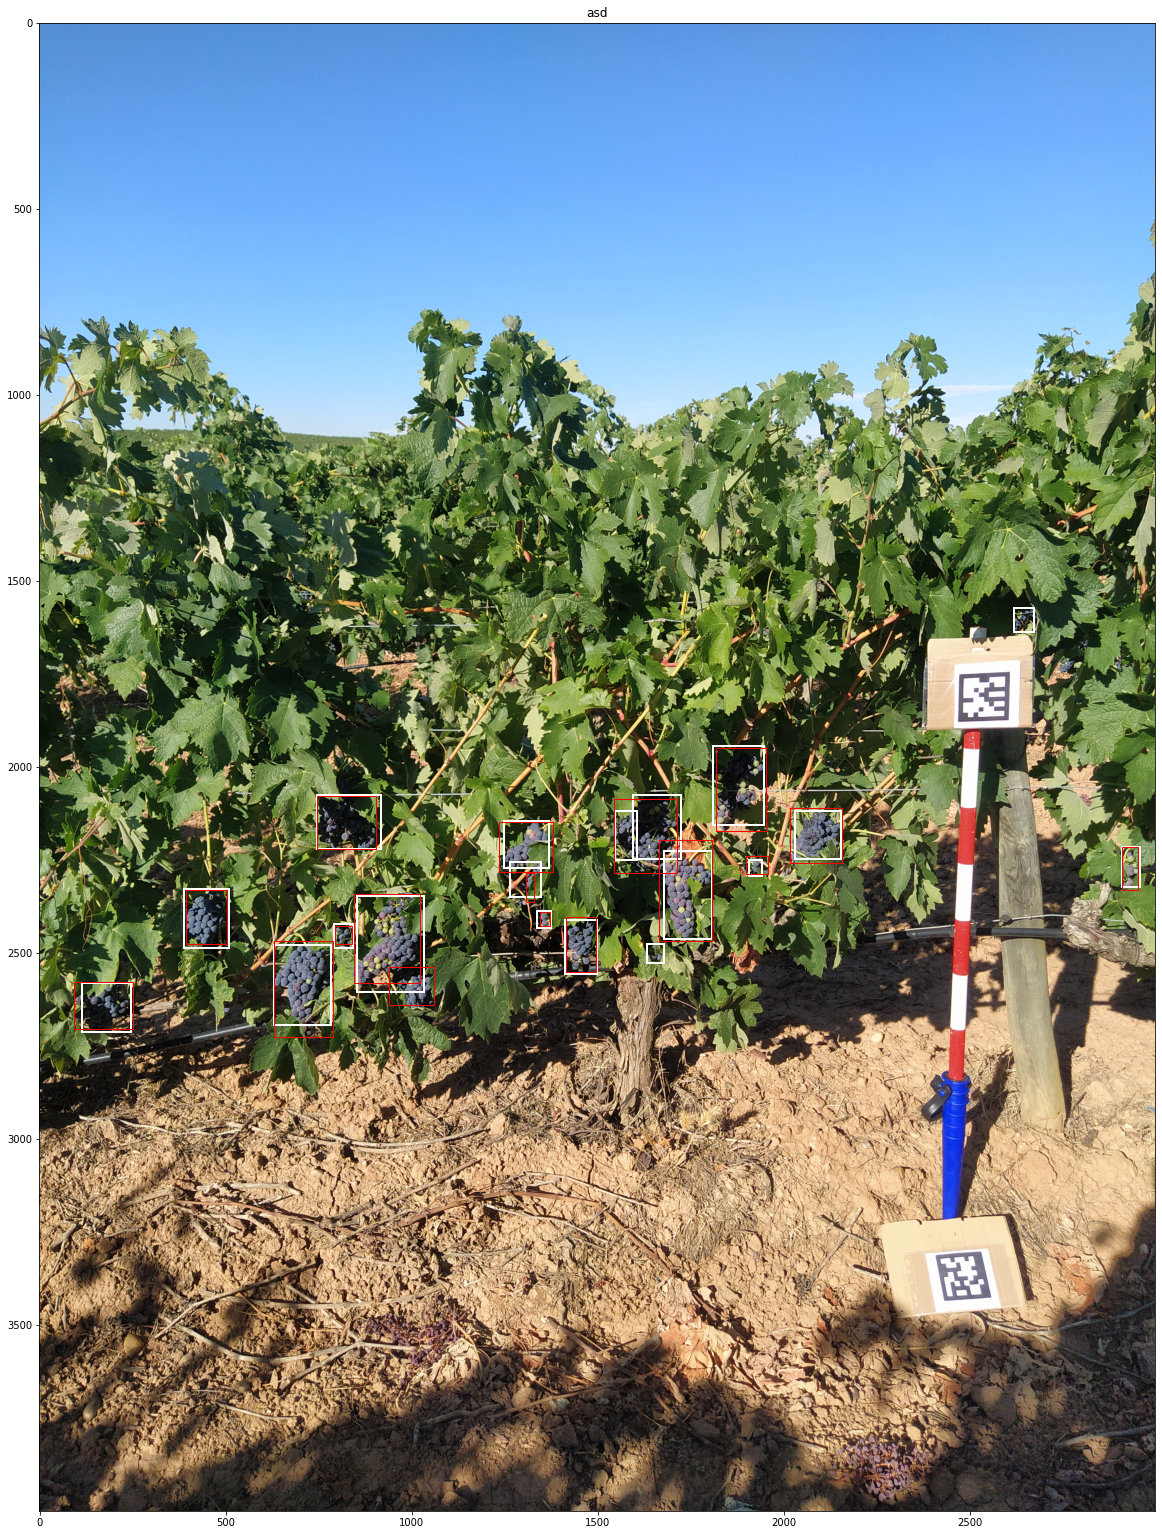

In [32]:
nms_threshold = 0.4
for i, filename in enumerate(VAL_DATASET.ids):
    plot_image(filename, model=models[0].to(device), nms_threshold=nms_threshold,title='asd', show_gt=True)
    break

### Study non detected boxes (Recall)

In [33]:
#""" use get_matching_boxes instead
from torchvision.ops import box_iou
def get_wrong_bboxes(gt, pred):
    all_ious = box_iou(gt['boxes'], pred['boxes'])
    not_matched_idxs = [i for i, ious in enumerate(all_ious) if ious.max() < 0.1]
    almost_matched_idxs = [i for i, ious in enumerate(all_ious) if (ious.max() >= 0.1) & (ious.max() < 0.7)]
    matched_idxs = [i for i, ious in enumerate(all_ious) if ious.max() >= 0.7]
    return gt['boxes'][not_matched_idxs], gt['boxes'][almost_matched_idxs], gt['boxes'][matched_idxs]


In [34]:
from torchvision.ops import box_iou
def get_matching_bboxes(gt_boxes, pred_boxes, lower_iou_thresh=0.0, upper_iou_thresh=1.0, find_gt_boxes=True):
    """
        find_gt_boxes: [bool] 
            if true will return boxes from ground truth where the
                iou thresholds are matched with a predicted bounding box.
            if false will return boxes from predictions where the
                iou thresholds are matched with a ground truth bounding box.
    """
    assert lower_iou_thresh <= upper_iou_thresh
    all_ious = box_iou(gt_boxes, pred_boxes)
    if not find_gt_boxes:
        all_ious = all_ious.permute(1,0)
    unmatched_idxs = [i for i, ious in enumerate(all_ious) if (ious.max() <= upper_iou_thresh) & (ious.max() >= lower_iou_thresh)]
    return gt_boxes[unmatched_idxs] if find_gt_boxes else pred_boxes[unmatched_idxs]

In [35]:
def get_classified_gt_boxes(model, split, max_batches=None):
    loader = get_dataset(split,'loader')
    not_matched = {}
    matched = {}
    almost_matched = {}
    ious = []
    for i, (data, target) in enumerate(loader):
        if max_batches and i >= max_batches:
            break
        data   = [d.permute(2, 0, 1).to(device) for d in data]
        target = [{key : elem.to(device) if type(elem) == torch.Tensor else elem for key, elem in t.items()} for t in target]
        with torch.no_grad():
            results = model(data)
        for t, r in zip(target, results):
            not_matched_curr = get_matching_bboxes(t["boxes"], r["boxes"],lower_iou_thresh=0.0, upper_iou_thresh=0.01)
            almost_matched_curr = get_matching_bboxes(t["boxes"], r["boxes"],lower_iou_thresh=0.01, upper_iou_thresh=0.7)
            matched_curr = get_matching_bboxes(t["boxes"], r["boxes"],lower_iou_thresh=0.7, upper_iou_thresh=1.0)
            not_matched_curr, almost_matched_curr, matched_curr = get_wrong_bboxes(t, r)
            not_matched[t["image_id_str"]] = not_matched_curr.cpu().numpy().copy()
            almost_matched[t["image_id_str"]] = almost_matched_curr.cpu().numpy().copy()
            matched[t["image_id_str"]] = matched_curr.cpu().numpy().copy()
            ious.append(box_iou(t["boxes"], r["boxes"]).max(1)[0].cpu().numpy().copy())
    return not_matched, almost_matched, matched, ious

In [36]:
not_matched, almost_matched, matched, ious = get_classified_gt_boxes(models[0].to(device), 'test')

CustomDatasetDataLoader
dataset [AI4EU] was created


In [37]:
all_matched_boxes = list(chain(*matched.values()))
all_almost_matched_boxes = list(chain(*almost_matched.values()))
all_not_matched_boxes = list(chain(*not_matched.values()))

In [38]:
matched_areas = [get_bbox_area(box).item() for box in all_matched_boxes]
almost_matched_areas = [get_bbox_area(box).item() for box in all_almost_matched_boxes]
not_matched_areas = [get_bbox_area(box).item() for box in all_not_matched_boxes]

In [39]:
def get_aspect_ratio(bbox):
    # Defined as torchivision -> height/width
    return (bbox[3] - bbox[1])/ (bbox[2] - bbox[0])

In [40]:
matched_aspect_ratio = [get_aspect_ratio(box).item() for box in all_matched_boxes]
almost_matched_aspect_ratio = [get_aspect_ratio(box).item() for box in all_almost_matched_boxes]
not_matched_aspect_ratio = [get_aspect_ratio(box).item() for box in all_not_matched_boxes]

In [41]:
def to_long_df(areas_list):
    names = [np.repeat(i, len(l)) for i, l in zip(['matched', 'almost_matched', 'not_matched'], areas_list)]
    df_areas = pd.DataFrame({"area":list(chain(*areas_list)), "key": list(chain(*names))})
    return df_areas

In [42]:
df_areas = to_long_df([matched_areas, almost_matched_areas, not_matched_areas])

In [43]:
bins=np.arange(df_areas["area"].min(), df_areas["area"].max(),2000)

In [44]:
len(all_matched_boxes)

342

In [45]:
print(f"#Didn't Match = {(df_areas['key'] == 'not_matched').sum()}\n" + \
f"#Almost Matched = {(df_areas['key'] == 'almost_matched').sum()}\n" + \
f"#Matched = {(df_areas['key'] == 'matched').sum()}")

#Didn't Match = 172
#Almost Matched = 278
#Matched = 342


In [46]:
fs = 14

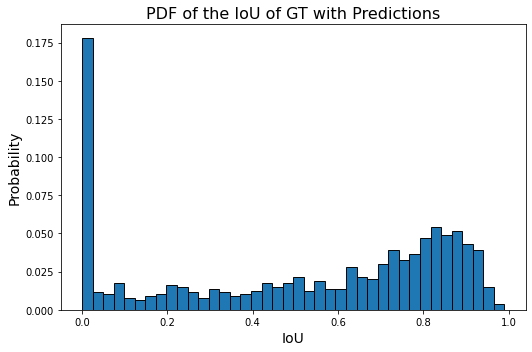

In [47]:
fig, ax =plt.subplots(figsize=(7.5, 5))
sns.histplot(list(chain(*ious)),stat='probability',ax=ax,alpha=1, bins=40)

ax.set_xlabel('IoU', fontsize=fs)
ax.set_ylabel('Probability', fontsize=fs)
#plt.suptitle('Area Density Distribution', fontsize=20, y = 0.95)
plt.title('PDF of the IoU of GT with Predictions', fontsize=16)
plt.tight_layout()
plt.savefig(os.path.join('figures', 'faster_boxes_iou_dist.png'), format='png',bbox_inches='tight')
#plt.scale('log')
fig.show()

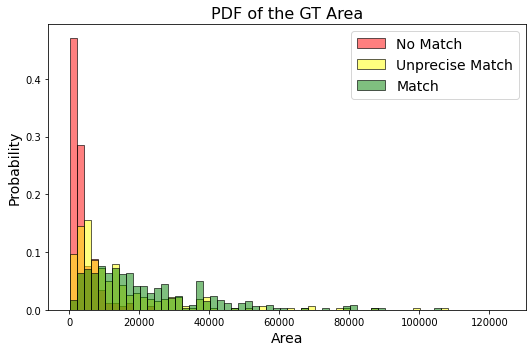

In [48]:
fig, ax =plt.subplots(figsize=(7.5, 5))
sns.histplot(df_areas[df_areas['key'] == 'not_matched'], x='area',stat='probability',ax=ax,color='red',alpha=0.5, label='No Match', bins=bins)
sns.histplot(df_areas[df_areas['key'] == 'almost_matched'], x='area',stat='probability', ax=ax, color='yellow',alpha=0.5, label='Unprecise Match', bins=bins)
sns.histplot(df_areas[df_areas['key'] == 'matched'], x='area',stat='probability', ax=ax, color='green',alpha=0.5, label='Match', bins=bins)

"""plt.annotate(
    f"#Didn't Match = {(df_areas['key'] == 'not_matched').sum()}\n" +
    f"#Almost Matched = {(df_areas['key'] == 'almost_matched').sum()}\n" +
    f"#Matched = {(df_areas['key'] == 'matched').sum()}",
    xy=(50000, 0.25), fontsize=14
)
"""
fs=14
ax.legend(fontsize=fs)
ax.set_xlabel('Area', fontsize=fs)
ax.set_ylabel('Probability', fontsize=fs)
#plt.suptitle('Area Density Distribution', fontsize=20, y = 0.95)
plt.title('PDF of the GT Area', fontsize=16)
plt.tight_layout()
plt.savefig(os.path.join('figures', 'faster_boxes_match_dist.png'), format='png',bbox_inches='tight')
fig.show()